# XGBoost

**Author**: Stephanie Golob

**contact**: estefaniagolob@gmail.com

**Date**: July 4, 2022

**Previous Notebook**: 6 of 7 (Decision Tree)

**Current & Final Notebook**: 7 of 7

---

In this notebook I'm going to use XGBoost Classifier models to see if I can improve the precision and recall scores for classes 2 and 3 using the original data and the balanced data sets (excluding the SMOTEN Upsampled data since it hasn't performed as well as the upsampled or downsampled data with the other models). 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>XGBoost</a></span><ul class="toc-item"><li><span><a href="#Basic-XGBoost-Model" data-toc-modified-id="Basic-XGBoost-Model-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Basic XGBoost Model</a></span></li><li><span><a href="#Model-Optimization-Using-Balanced-and-Imbalanced-Data-Sets" data-toc-modified-id="Model-Optimization-Using-Balanced-and-Imbalanced-Data-Sets-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Model Optimization Using Balanced and Imbalanced Data Sets</a></span><ul class="toc-item"><li><span><a href="#Model-Optimization-with-Upsampled-Data" data-toc-modified-id="Model-Optimization-with-Upsampled-Data-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Model Optimization with Upsampled Data</a></span></li><li><span><a href="#Model-Optimization-with-Downsampled-Data" data-toc-modified-id="Model-Optimization-with-Downsampled-Data-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Model Optimization with Downsampled Data</a></span></li></ul></li><li><span><a href="#Model-Summary-Table" data-toc-modified-id="Model-Summary-Table-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Model Summary Table</a></span></li><li><span><a href="#Feature-Evaluation" data-toc-modified-id="Feature-Evaluation-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Feature Evaluation</a></span></li><li><span><a href="#Results-Using-Test-Data" data-toc-modified-id="Results-Using-Test-Data-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Results Using Test Data</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></li></ul></div>

---

Import the required libraries.

In [155]:
# standard libraries
import numpy as np
import pandas as pd

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# for saving the model outputs
import joblib

# xgboost algorithm 
from xgboost import XGBClassifier

# for searching through model parameters with cross-validation
from sklearn.model_selection import GridSearchCV

# confusion matrix and classification reports
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report

# feature evaluation
import shap

Read in the X_train, y_train, X_validation and y_validation data sets using `read_pickle`.

In [3]:
X_train = pd.read_pickle("data/X_train.pkl")
y_train = pd.read_pickle("data/y_train.pkl")

X_validation = pd.read_pickle("data/X_validation.pkl")
y_validation = pd.read_pickle("data/y_validation.pkl")

---

## Basic XGBoost Model

Fit a basic XGBoost model on original data set first.

In [157]:
my_xgb = XGBClassifier(random_state = 10)

my_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=10, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [158]:
# check the accuracy score on the training and validation sets
print(f"The Training accuracy is:  {my_xgb.score(X_train, y_train)}")
print(f"The Validation accuracy is:  {my_xgb.score(X_validation, y_validation)}")

The Training accuracy is:  0.7715860581065703
The Validation accuracy is:  0.7632239300760477


The training and validation accuracy are quite similar, this shows that the model has not overfit to the training data. But I want to check the results of the confusion matrix and the classification report to know how the model is predicting the classes.

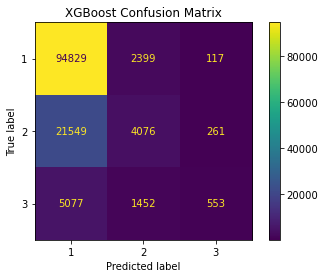

In [159]:
plot_confusion_matrix(my_xgb, X_validation, y_validation)
plt.title("XGBoost Confusion Matrix");

Calculate the model predictions using X_validation.

In [160]:
y_predictions = my_xgb.predict(X_validation)

Create the classification report.

In [161]:
report = classification_report(y_validation, y_predictions)
print(report)

              precision    recall  f1-score   support

           1       0.78      0.97      0.87     97345
           2       0.51      0.16      0.24     25886
           3       0.59      0.08      0.14      7082

    accuracy                           0.76    130313
   macro avg       0.63      0.40      0.42    130313
weighted avg       0.72      0.76      0.70    130313



The base XGBoost model is performing slightly better than the base Decision Tree model, and much better than the base Logistic Regression model. I want to try and optimize the hyperparameters to see if I can further improve the scores.

---

Use `gridsearchcv` to loop through different number of estimators and max depth values to see what parameters are appropriate for the data.

In [7]:
# instantiate the model
my_xgb = XGBClassifier(random_state = 10)

# set the parameters for the grid
param_grid = {'n_estimators': np.arange(1, 1000, 100), 
              'max_depth': np.arange(1, 5)}

grid_xgb = GridSearchCV(my_xgb, param_grid = param_grid, verbose = 2, cv = 5)

grid_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END ........................max_depth=1, n_estimators=1; total time=   0.3s
[CV] END ........................max_depth=1, n_estimators=1; total time=   0.3s
[CV] END ........................max_depth=1, n_estimators=1; total time=   0.3s
[CV] END ........................max_depth=1, n_estimators=1; total time=   0.3s
[CV] END ........................max_depth=1, n_estimators=1; total time=   0.3s
[CV] END ......................max_depth=1, n_estimators=101; total time=   4.1s
[CV] END ......................max_depth=1, n_estimators=101; total time=   4.0s
[CV] END ......................max_depth=1, n_estimators=101; total time=   4.1s
[CV] END ......................max_depth=1, n_estimators=101; total time=   3.9s
[CV] END ......................max_depth=1, n_estimators=101; total time=   4.0s
[CV] END ......................max_depth=1, n_estimators=201; total time=   8.1s
[CV] END ......................max_depth=1, n_e

[CV] END ........................max_depth=3, n_estimators=1; total time=   0.4s
[CV] END ........................max_depth=3, n_estimators=1; total time=   0.4s
[CV] END ........................max_depth=3, n_estimators=1; total time=   0.4s
[CV] END ........................max_depth=3, n_estimators=1; total time=   0.4s
[CV] END ......................max_depth=3, n_estimators=101; total time=   9.6s
[CV] END ......................max_depth=3, n_estimators=101; total time=   9.4s
[CV] END ......................max_depth=3, n_estimators=101; total time=   9.7s
[CV] END ......................max_depth=3, n_estimators=101; total time=   9.6s
[CV] END ......................max_depth=3, n_estimators=101; total time=   9.5s
[CV] END ......................max_depth=3, n_estimators=201; total time=  18.8s
[CV] END ......................max_depth=3, n_estimators=201; total time=  18.7s
[CV] END ......................max_depth=3, n_estimators=201; total time=  18.5s
[CV] END ...................

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameter

Create a dataframe to store the results of the gridsearch so that the results can be plotted to see what the optimal values are.

In [11]:
results_df = pd.DataFrame({
    "n_estimators": grid_xgb.cv_results_["param_n_estimators"],
    'max_depth': grid_xgb.cv_results_["param_max_depth"].astype(str),
    'mean_score': grid_xgb.cv_results_["mean_test_score"]
})

results_df.head()

,n_estimators,max_depth,mean_score
0,1,1,0.747015
1,101,1,0.748620
2,201,1,0.749485
3,301,1,0.749975
4,401,1,0.750327


Plot the results of the gridsearch.

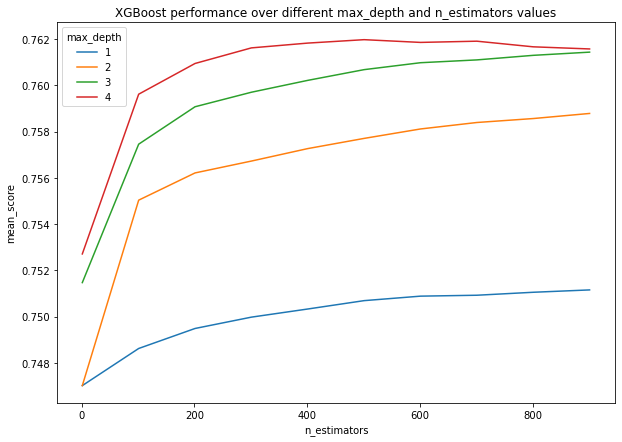

In [12]:
plt.figure(figsize = (10, 7))

# plot the scores for each max depth fit
sns.lineplot(x = "n_estimators", y = "mean_score", hue = "max_depth", data = results_df)

# set the axes labels and plot title
plt.xlabel("Number of estimators")
plt.ylabel("Mean score")
plt.title("XGBoost performance over different max_depth and n_estimators values")

plt.show()

The mean score of the model is higher with a max depth of 4, around 500 estimators the model performance doesn't improve anymore indicating that less estimators could be used in the next grid search. I also want to test the effect of a range of learning rates on the model performance.

---

From above we can see that increasing the max depth increases the model performance so I'm going to start with some higher max depth values here. Since XGBoost is a computationally expensive model to run I'm going to keep the number of estimators constant, and reduce the number of cross-validations to 2 so I can reduce the run-time. I want to test the effect of different learning rates, starting with lower rates to see if I can deduce which is more appropriate for the data.

In [21]:
# instantiate the model
my_xgb = XGBClassifier()

# set the parameters for the grid
# try with only 100 estimators
param_grid = {'n_estimators': [100],
              'learning_rate': [0.01, 0.05, 0.1],
              'max_depth': [5, 10, 15]}

grid_xgb2 = GridSearchCV(my_xgb, param_grid = param_grid, verbose = 2, cv = 2)

grid_xgb2.fit(X_train, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=  10.5s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=  10.5s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=100; total time=  26.5s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=100; total time=  25.9s
[CV] END .learning_rate=0.01, max_depth=15, n_estimators=100; total time=  45.1s
[CV] END .learning_rate=0.01, max_depth=15, n_estimators=100; total time=  46.8s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=100; total time=  11.3s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=100; total time=  10.8s
[CV] END .learning_rate=0.05, max_depth=10, n_estimators=100; total time=  26.2s
[CV] END .learning_rate=0.05, max_depth=10, n_estimators=100; total time=  26.1s
[CV] END .learning_rate=0.05, max_depth=15, n_estimators=100; total time=  45.7s
[CV] END .learning_rate=0.05, max_depth=15, n_est

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

Store the results of gridsearch in a dataframe that can be used to plot the results.

In [190]:
results_df2 = pd.DataFrame({
    "n_estimators": grid_xgb2.cv_results_["param_n_estimators"],
    'max_depth': grid_xgb2.cv_results_["param_max_depth"],
    'mean_score': grid_xgb2.cv_results_["mean_test_score"],
    'learning_rate': grid_xgb2.cv_results_["param_learning_rate"]
})

results_df2

,n_estimators,max_depth,mean_score,learning_rate
0,100,5,0.753557,0.01
1,100,10,0.757500,0.01
2,100,15,0.753909,0.01
3,100,5,0.755829,0.05
4,100,10,0.760529,0.05
5,100,15,0.755655,0.05
6,100,5,0.758036,0.1
7,100,10,0.760753,0.1
8,100,15,0.753767,0.1


Plot the results, use max_depth as the range of x-values since the number of estimators is constant in this experiment. 

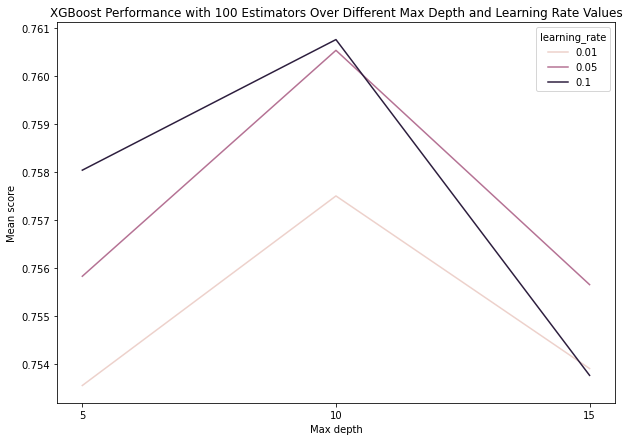

In [185]:
plt.figure(figsize = (10, 7))

sns.lineplot(x = "max_depth", y = "mean_score", hue = 'learning_rate', data = results_df2)

plt.xlabel("Max depth")
plt.ylabel("Mean score")
plt.title("XGBoost Performance with 100 Estimators Over Different Max Depth and Learning Rate Values")

plt.show()

These results show that for all learning rates the mean score improves at a max depth of 10 and then sharply decreases at a max depth of 15. The mean scores for the learning rates of 0.1 and 0.05 are higher than for the learning rate of 0.01, in future experiments 0.01 could be excluded to further reduce run-time since it's not increasing the model performance. 

---

In the previous experiment I used low learning rates (0.01-0.1), I want to test whether a higher learning rate would improve the results. I'm using 2-fold cross-validation to compare a learning rate of 0.5 with max depth values of 5 and 10, keeping the number of estimators constant at 100. If the mean scores are lower than in the previous experiment with lower learning rates than I exclude a higher learning rate from the final gridsearch. 

In [54]:
# instantiate the model
my_xgb = XGBClassifier()

# set the parameters for the grid
# try with only 100 estimators
param_grid = {'n_estimators': [100],
              'learning_rate': [0.5],
              'max_depth': [5, 10]}

grid_xgb5 = GridSearchCV(my_xgb, param_grid = param_grid, verbose = 2, cv = 2)

grid_xgb5.fit(X_train, y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] END ...learning_rate=0.5, max_depth=5, n_estimators=100; total time=  10.5s
[CV] END ...learning_rate=0.5, max_depth=5, n_estimators=100; total time=  10.8s
[CV] END ..learning_rate=0.5, max_depth=10, n_estimators=100; total time=  26.3s
[CV] END ..learning_rate=0.5, max_depth=10, n_estimators=100; total time=  25.1s


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

Save the results in a dataframe.

In [188]:
results_df5 = pd.DataFrame({
    "n_estimators": grid_xgb5.cv_results_["param_n_estimators"],
    'max_depth': grid_xgb5.cv_results_["param_max_depth"],
    'mean_score': grid_xgb5.cv_results_["mean_test_score"],
    'learning_rate': grid_xgb5.cv_results_["param_learning_rate"]
})

results_df5

,n_estimators,max_depth,mean_score,learning_rate
0,100,5,0.760805,0.5
1,100,10,0.747657,0.5


Plot the results.

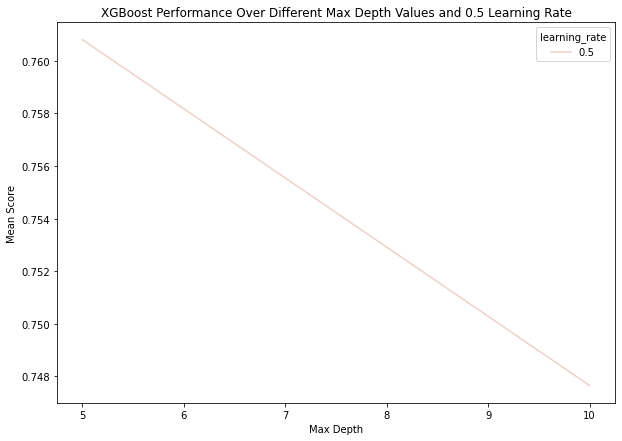

In [189]:
plt.figure(figsize = (10, 7))
sns.lineplot(x = "max_depth", y = "mean_score", hue = 'learning_rate', data = results_df5)

plt.xlabel("Max Depth")
plt.ylabel("Mean Score")
plt.title("XGBoost Performance Over Different Max Depth Values and 0.5 Learning Rate")

plt.show()

The learning rate of 0.5 produces a mean score similar to a learning rate of 0.05 or 0.1. The mean scores decreases from a max depth of 5 to a max depth of 10. This is enough justification to include a learning rate of 0.5 in the final gridsearch. I want to do one more test using a learning rate of 0.7 to see if the mean score improves more, or if I can use a maximum learning rate of 0.5.

---

Repeat the experiment from above using a learning rate of 0.7, with max depth of 5 and 10 and keep the number of estimators constant at 100.

In [64]:
# instantiate the model
my_xgb = XGBClassifier()

# set the parameters for the grid
# try with only 100 estimators
param_grid = {'n_estimators': [100],
              'learning_rate': [0.7],
              'max_depth': [5, 10]}

# instantiate the grid
grid_xgb6 = GridSearchCV(my_xgb, param_grid = param_grid, verbose = 2, cv = 2)

# fit the grid
grid_xgb6.fit(X_train, y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] END ...learning_rate=0.7, max_depth=5, n_estimators=100; total time=  10.7s
[CV] END ...learning_rate=0.7, max_depth=5, n_estimators=100; total time=  10.7s
[CV] END ..learning_rate=0.7, max_depth=10, n_estimators=100; total time=  25.7s
[CV] END ..learning_rate=0.7, max_depth=10, n_estimators=100; total time=  24.8s


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

Save the results in a dataframe so they can be plotted below.

In [191]:
results_df6 = pd.DataFrame({
    "n_estimators": grid_xgb6.cv_results_["param_n_estimators"],
    'max_depth': grid_xgb6.cv_results_["param_max_depth"],
    'mean_score': grid_xgb6.cv_results_["mean_test_score"],
    'learning_rate': grid_xgb6.cv_results_["param_learning_rate"]
})

results_df6

,n_estimators,max_depth,mean_score,learning_rate
0,100,5,0.759457,0.7
1,100,10,0.739625,0.7


Plot the results.

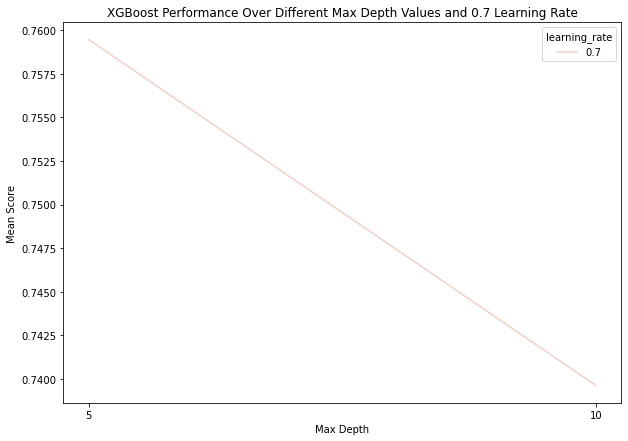

In [182]:
plt.figure(figsize = (10, 7))

sns.lineplot(x = "max_depth", y = "mean_score", hue = 'learning_rate', data = results_df6)

plt.xlabel("Max Depth")
plt.ylabel("Mean Score")
plt.title("XGBoost Performance Over Different Max Depth Values and 0.7 Learning Rate")

plt.show()

The mean score is slightly reduced as compared to a learning rate of 0.5, so I will keep the maximum learning rate at 0.5.

---

I want to test the same parameters using a constant number of estimators of 500, I'm going to exclude the learning rate of 0.01 since it performed the worst from the experiments above and I'm going to use max depth values of 5, 10 and 15. I'm going to use 2-fold cross-validation to reduce the run-time.

In [35]:
# instantiate the model
my_xgb = XGBClassifier()

# set the parameters for the grid
# try with only 500 estimators
param_grid = {'n_estimators': [500],
              'learning_rate': [0.05, 0.1],
              'max_depth': [5, 10, 15]}

#instantiate the grid
grid_xgb3 = GridSearchCV(my_xgb, param_grid = param_grid, verbose = 2, cv = 2)

# fit the grid
grid_xgb3.fit(X_train, y_train)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=500; total time=  52.7s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=500; total time=  52.2s
[CV] END .learning_rate=0.05, max_depth=10, n_estimators=500; total time= 2.1min
[CV] END .learning_rate=0.05, max_depth=10, n_estimators=500; total time= 2.1min
[CV] END .learning_rate=0.05, max_depth=15, n_estimators=500; total time= 3.7min
[CV] END .learning_rate=0.05, max_depth=15, n_estimators=500; total time= 3.7min
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=500; total time=  51.9s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=500; total time=  52.0s
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=500; total time= 2.1min
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=500; total time= 2.0min
[CV] END ..learning_rate=0.1, max_depth=15, n_estimators=500; total time= 3.6min
[CV] END ..learning_rate=0.1, max_depth=15, n_est

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

Store the results in a dataframe.

In [192]:
results_df3 = pd.DataFrame({
    "n_estimators": grid_xgb3.cv_results_["param_n_estimators"],
    'max_depth': grid_xgb3.cv_results_["param_max_depth"],
    'mean_score': grid_xgb3.cv_results_["mean_test_score"],
    'learning_rate': grid_xgb3.cv_results_["param_learning_rate"]
})

results_df3

,n_estimators,max_depth,mean_score,learning_rate
0,500,5,0.759891,0.05
1,500,10,0.759026,0.05
2,500,15,0.749278,0.05
3,500,5,0.760845,0.1
4,500,10,0.754560,0.1
5,500,15,0.744618,0.1


Plot the results.

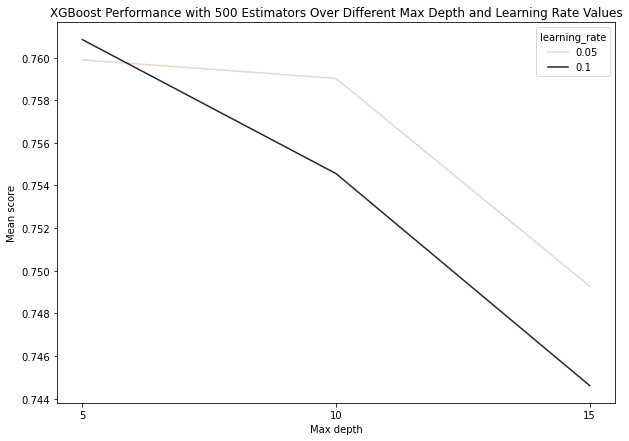

In [186]:
plt.figure(figsize = (10, 7))

sns.lineplot(x = "max_depth", y = "mean_score", hue = 'learning_rate', data = results_df3)

plt.xlabel("Max depth")
plt.ylabel("Mean score")
plt.title("XGBoost Performance with 500 Estimators Over Different Max Depth and Learning Rate Values")

plt.show()

Using 500 estimators the model performs better with a higher learning rate of 0.1. The mean score decreases for both learning rates with higher max depth values. The sharp decrease in mean score with a max depth of 15 is consistent with the results from 100 estimators, further evidence that I can limit the max depth values to 10 in the final gridsearch. 

---

The final experiment I want to run is using 1000 estimators, a learning rate of 0.05 and 0.1 and max depth values of 5, 10 and 15. I want to see if increasing the number of estimators further improves the model performance. 

In [42]:
# instantiate the model
my_xgb = XGBClassifier()

# set the parameters for the grid
# try with only 1000 estimators
param_grid = {'n_estimators': [1000],
              'learning_rate': [0.05, 0.1],
              'max_depth': [5, 10, 15]}

#instantiate the grid
grid_xgb4 = GridSearchCV(my_xgb, param_grid = param_grid, verbose = 2, cv = 2)

#fit the grid
grid_xgb4.fit(X_train, y_train)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] END .learning_rate=0.05, max_depth=5, n_estimators=1000; total time= 1.7min
[CV] END .learning_rate=0.05, max_depth=5, n_estimators=1000; total time= 1.7min
[CV] END learning_rate=0.05, max_depth=10, n_estimators=1000; total time= 4.1min
[CV] END learning_rate=0.05, max_depth=10, n_estimators=1000; total time= 4.1min
[CV] END learning_rate=0.05, max_depth=15, n_estimators=1000; total time= 7.3min
[CV] END learning_rate=0.05, max_depth=15, n_estimators=1000; total time= 7.3min
[CV] END ..learning_rate=0.1, max_depth=5, n_estimators=1000; total time= 1.7min
[CV] END ..learning_rate=0.1, max_depth=5, n_estimators=1000; total time= 1.7min
[CV] END .learning_rate=0.1, max_depth=10, n_estimators=1000; total time= 4.1min
[CV] END .learning_rate=0.1, max_depth=10, n_estimators=1000; total time= 4.1min
[CV] END .learning_rate=0.1, max_depth=15, n_estimators=1000; total time= 7.2min
[CV] END .learning_rate=0.1, max_depth=15, n_esti

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

Store the results in a dataframe.

In [193]:
results_df4 = pd.DataFrame({
    "n_estimators": grid_xgb4.cv_results_["param_n_estimators"],
    'max_depth': grid_xgb4.cv_results_["param_max_depth"],
    'mean_score': grid_xgb4.cv_results_["mean_test_score"],
    'learning_rate': grid_xgb4.cv_results_["param_learning_rate"]
})

results_df4

,n_estimators,max_depth,mean_score,learning_rate
0,1000,5,0.760986,0.05
1,1000,10,0.754918,0.05
2,1000,15,0.744828,0.05
3,1000,5,0.760421,0.1
4,1000,10,0.748699,0.1
5,1000,15,0.740586,0.1


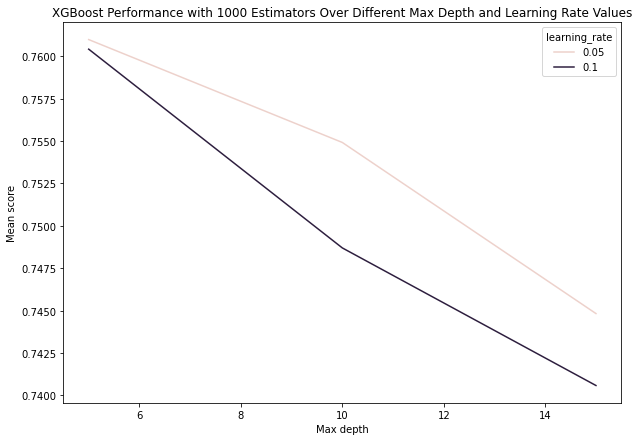

In [194]:
plt.figure(figsize = (10, 7))

sns.lineplot(x = "max_depth", y = "mean_score", hue = 'learning_rate', data = results_df4)

plt.xlabel("Max depth")
plt.ylabel("Mean score")
plt.title("XGBoost Performance with 1000 Estimators Over Different Max Depth and Learning Rate Values")

plt.show()

The mean score using 1000 estimators is roughly the same as using 100 or 500 estimators. Model performance decreases with greater max depth values for both learning rates. Since the run-time is much greater using more estimators and the model performance hasn't improved I will not include 1000 estimators as a parameter in the final gridsearch.

---

Compare the results of all of the mini-experiments by concatenating the results of each gridsearch output into one dataframe.

In [197]:
results_all = pd.concat([results_df2, results_df3, results_df4])

Reset the index to plot the values.

In [198]:
results_all = results_all.reset_index()
results_all

,index,n_estimators,max_depth,mean_score,learning_rate
0,0,100,5,0.753557,0.01
1,1,100,10,0.757500,0.01
2,2,100,15,0.753909,0.01
3,3,100,5,0.755829,0.05
4,4,100,10,0.760529,0.05
5,5,100,15,0.755655,0.05
6,6,100,5,0.758036,0.1
7,7,100,10,0.760753,0.1
8,8,100,15,0.753767,0.1
9,0,500,5,0.759891,0.05


Plot the results.

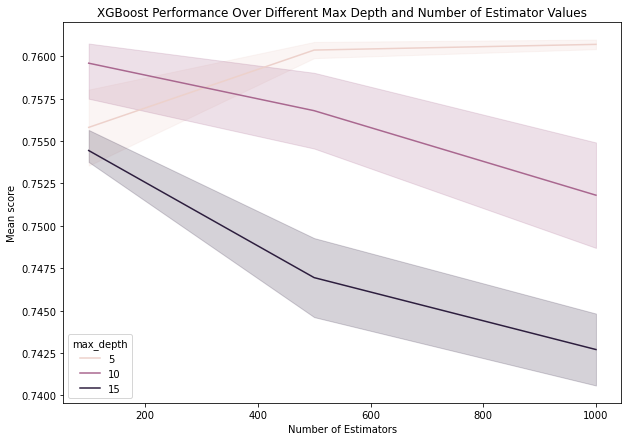

In [201]:
plt.figure(figsize = (10, 7))

sns.lineplot(x = "n_estimators", y = "mean_score", hue = 'max_depth', data = results_all)

# set the plot title and axes labels
plt.title("XGBoost Performance Over Different Max Depth and Number of Estimator Values")
plt.xlabel("Number of Estimators")
plt.ylabel("Mean score")

plt.show()

The model performance is best with a max depth of 5. Beyond 500 estimators the model does not improve significantly with max depth 5. A max depth of 15 performs the worst overall, and gets worse with an increasing number of estimators. Likewise for a max depth of 10 the model performance decreases with more estimators. I'm going to include the top performing parameters in a more robust gridsearch to see the overall performance on the original imbalanced data.

---

## Model Optimization Using Balanced and Imbalanced Data Sets

I'm going to input the top performing parameters in a gridsearch with 5-fold cross-validation to optimize the XGBoost models using the balanced and imbalanced data sets. I will then make predictions and compare the model outputs using the confusion matrices and precision, recall and f1-scores. Since the SMOTEN upsampled data has so far performed worse than the upsampled and downsampled data I'm going to exclude it from these tests and just focus on optimizing the data sets that offer more promising results.

- First - original imbalanced data
- Second - Upsampled data
- Third - Downsampled data

The parameters I'm going to test in this gridsearch are:
- n_estimators 100 and 500
- learning rate 0.05, 0.1 and 0.5
- max depth 1-10

In [92]:
# instantiate the model
my_xgb = XGBClassifier()

# set the parameters for the grid
parameters = {'n_estimators': [100, 500],
              'learning_rate': [0.05, 0.1, 0.5],
              'max_depth': np.arange(1, 11)}

#instantiate the grid
imbalanced_grid = GridSearchCV(my_xgb, param_grid = parameters, verbose = 2, cv = 5)

#fit the grid
imbalanced_grid.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END ..learning_rate=0.05, max_depth=1, n_estimators=100; total time=   4.0s
[CV] END ..learning_rate=0.05, max_depth=1, n_estimators=100; total time=   3.9s
[CV] END ..learning_rate=0.05, max_depth=1, n_estimators=100; total time=   4.1s
[CV] END ..learning_rate=0.05, max_depth=1, n_estimators=100; total time=   3.9s
[CV] END ..learning_rate=0.05, max_depth=1, n_estimators=100; total time=   4.0s
[CV] END ..learning_rate=0.05, max_depth=1, n_estimators=500; total time=  18.5s
[CV] END ..learning_rate=0.05, max_depth=1, n_estimators=500; total time=  18.9s
[CV] END ..learning_rate=0.05, max_depth=1, n_estimators=500; total time=  19.1s
[CV] END ..learning_rate=0.05, max_depth=1, n_estimators=500; total time=  18.9s
[CV] END ..learning_rate=0.05, max_depth=1, n_estimators=500; total time=  18.6s
[CV] END ..learning_rate=0.05, max_depth=2, n_estimators=100; total time=   6.5s
[CV] END ..learning_rate=0.05, max_depth=2, n_e

[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=100; total time=   4.0s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=100; total time=   4.0s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=100; total time=   4.1s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=100; total time=   4.1s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=500; total time=  18.7s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=500; total time=  18.5s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=500; total time=  18.8s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=500; total time=  19.1s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=500; total time=  18.4s
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=100; total time=   6.4s
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=100; total time=   6.2s
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=100; total time=   6.4s
[CV] END ...learning_rate=0.

[CV] END ...learning_rate=0.5, max_depth=1, n_estimators=100; total time=   4.0s
[CV] END ...learning_rate=0.5, max_depth=1, n_estimators=100; total time=   4.1s
[CV] END ...learning_rate=0.5, max_depth=1, n_estimators=500; total time=  18.8s
[CV] END ...learning_rate=0.5, max_depth=1, n_estimators=500; total time=  19.2s
[CV] END ...learning_rate=0.5, max_depth=1, n_estimators=500; total time=  18.6s
[CV] END ...learning_rate=0.5, max_depth=1, n_estimators=500; total time=  18.5s
[CV] END ...learning_rate=0.5, max_depth=1, n_estimators=500; total time=  19.5s
[CV] END ...learning_rate=0.5, max_depth=2, n_estimators=100; total time=   6.4s
[CV] END ...learning_rate=0.5, max_depth=2, n_estimators=100; total time=   6.4s
[CV] END ...learning_rate=0.5, max_depth=2, n_estimators=100; total time=   6.4s
[CV] END ...learning_rate=0.5, max_depth=2, n_estimators=100; total time=   6.4s
[CV] END ...learning_rate=0.5, max_depth=2, n_estimators=100; total time=   6.4s
[CV] END ...learning_rate=0.

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

Save the model outputs using `dump` from the joblib library.

In [136]:
joblib.dump(imbalanced_grid, 'xgb_imbalanced.pkl')

['xgb_imbalanced.pkl']

Store the results in a dataframe.

In [205]:
results_imbalanced = pd.DataFrame({
    "n_estimators": imbalanced_grid.cv_results_["param_n_estimators"],
    'max_depth': imbalanced_grid.cv_results_["param_max_depth"],
    'mean_score': imbalanced_grid.cv_results_["mean_test_score"],
    'learning_rate': imbalanced_grid.cv_results_["param_learning_rate"]
})

results_imbalanced

,n_estimators,max_depth,mean_score,learning_rate
0,100,1,0.747015,0.05
1,500,1,0.748196,0.05
2,100,2,0.748071,0.05
3,500,2,0.754599,0.05
4,100,3,0.752501,0.05
5,500,3,0.756888,0.05
6,100,4,0.754583,0.05
7,500,4,0.758638,0.05
8,100,5,0.755941,0.05
9,500,5,0.760756,0.05


Plot the results.

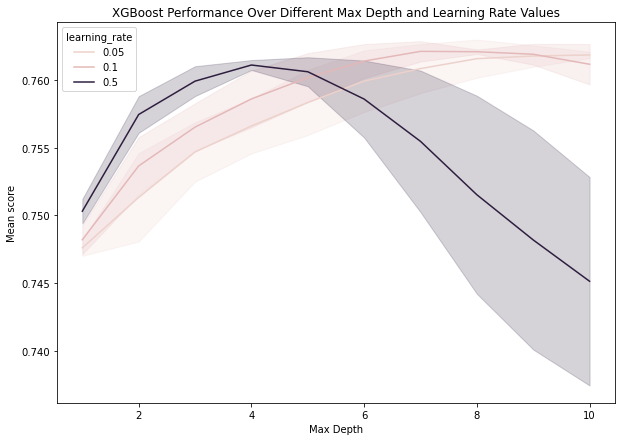

In [206]:
plt.figure(figsize = (10, 7))

sns.lineplot(x = "max_depth", y = "mean_score", hue = 'learning_rate', data = results_imbalanced)

# set the plot title and axes labels
plt.title("XGBoost Performance Over Different Max Depth and Learning Rate Values")
plt.xlabel("Max Depth")
plt.ylabel("Mean score")

plt.show()

The model performs best with a learning rate of 0.1 and 0.05. After a max depth of 4 the mean score for the learning rate of 0.5 decreases significantly. The model appears to achieve peak performance with a learning rate of 0.1 and a max depth of 7, from the results table I can see there is a slight increase in model performance with 500 estimators as compared to 100. 

Using `best_estimator` I can see what gridsearch chose as the optimized parameters.

In [212]:
imbalanced_grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Gridsearch output the optimized parameters as a max depth of 8, a learning rate of 0.05 and 500 estimators. These results are surprising because the mean score of the model is reduced according to the plot above. I will use the parameters from the plot to re-fit an XGBClassifier and see how the model is making predictions.

In [207]:
# instantiate the model
imbalanced_xgb = XGBClassifier(learning_rate = 0.1, random_state = 10, max_depth = 7, n_estimators = 500)

# fit the model on the original data
imbalanced_xgb = imbalanced_xgb.fit(X_train, y_train)

Check the training and validation accuracy scores.

In [208]:
print(f"The Training accuracy is:  {imbalanced_xgb.score(X_train, y_train)}")
print(f"The Validation accuracy is:  {imbalanced_xgb.score(X_validation, y_validation)}")

The Training accuracy is:  0.7860041702021299
The Validation accuracy is:  0.7633006683907207


The model has not overfit to the training data, but I want to check the confusion matrix and classification report to get a better idea of how the model is making predictions.

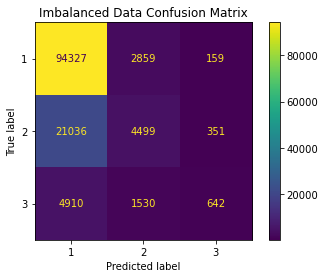

In [209]:
plot_confusion_matrix(imbalanced_xgb, X_validation, y_validation)
plt.title("Imbalanced Data Confusion Matrix");

The model is still predicting class 1 the majority of the time, this is not a huge improvement over the base model.

Calculate the predictions using X_validation.

In [210]:
y_predictions_imbalanced = imbalanced_xgb.predict(X_validation)

Create the classification report.

In [211]:
report_imbalanced = classification_report(y_validation, y_predictions_imbalanced)
print(report_imbalanced)

              precision    recall  f1-score   support

           1       0.78      0.97      0.87     97345
           2       0.51      0.17      0.26     25886
           3       0.56      0.09      0.16      7082

    accuracy                           0.76    130313
   macro avg       0.62      0.41      0.43    130313
weighted avg       0.72      0.76      0.71    130313



The f1-scores have improved slightly as compared to the base model, but it's still predicting class 1 mostly. Next I will run a gridsearch to see if the outputs improve using the upsampled balanced data.

---

### Model Optimization with Upsampled Data

Read in the upsampled data.

In [102]:
X_train_up = pd.read_pickle("data/X_train_over.pkl")
y_train_up = pd.read_pickle("data/y_train_over.pkl")

Run a gridsearch using 5-fold cross-validation and the same hyperparameters as above.

In [106]:
# instantiate the model
my_xgb = XGBClassifier()

# set the parameters for the grid
parameters = {'n_estimators': [100, 500],
              'learning_rate': [0.05, 0.1, 0.5],
              'max_depth': np.arange(1, 11)}

#instantiate the grid
up_grid = GridSearchCV(my_xgb, param_grid = parameters, verbose = 2, cv = 5)

#fit the grid
up_grid.fit(X_train_up, y_train_up)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END ..learning_rate=0.05, max_depth=1, n_estimators=100; total time=   8.6s
[CV] END ..learning_rate=0.05, max_depth=1, n_estimators=100; total time=   8.8s
[CV] END ..learning_rate=0.05, max_depth=1, n_estimators=100; total time=   8.5s
[CV] END ..learning_rate=0.05, max_depth=1, n_estimators=100; total time=   8.6s
[CV] END ..learning_rate=0.05, max_depth=1, n_estimators=100; total time=   8.5s
[CV] END ..learning_rate=0.05, max_depth=1, n_estimators=500; total time=  40.5s
[CV] END ..learning_rate=0.05, max_depth=1, n_estimators=500; total time=  39.9s
[CV] END ..learning_rate=0.05, max_depth=1, n_estimators=500; total time=  40.9s
[CV] END ..learning_rate=0.05, max_depth=1, n_estimators=500; total time=  41.4s
[CV] END ..learning_rate=0.05, max_depth=1, n_estimators=500; total time=  40.9s
[CV] END ..learning_rate=0.05, max_depth=2, n_estimators=100; total time=  13.7s
[CV] END ..learning_rate=0.05, max_depth=2, n_e

[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=100; total time=   9.3s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=100; total time=   9.4s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=100; total time=   9.3s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=100; total time=   9.4s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=500; total time=  44.8s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=500; total time=  45.1s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=500; total time=  44.9s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=500; total time=  44.3s
[CV] END ...learning_rate=0.1, max_depth=1, n_estimators=500; total time=  44.5s
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=100; total time=  15.4s
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=100; total time=  14.9s
[CV] END ...learning_rate=0.1, max_depth=2, n_estimators=100; total time=  15.2s
[CV] END ...learning_rate=0.

[CV] END ...learning_rate=0.5, max_depth=1, n_estimators=100; total time=   9.4s
[CV] END ...learning_rate=0.5, max_depth=1, n_estimators=100; total time=   9.2s
[CV] END ...learning_rate=0.5, max_depth=1, n_estimators=500; total time=  44.0s
[CV] END ...learning_rate=0.5, max_depth=1, n_estimators=500; total time=  44.6s
[CV] END ...learning_rate=0.5, max_depth=1, n_estimators=500; total time=  45.0s
[CV] END ...learning_rate=0.5, max_depth=1, n_estimators=500; total time=  45.3s
[CV] END ...learning_rate=0.5, max_depth=1, n_estimators=500; total time=  44.9s
[CV] END ...learning_rate=0.5, max_depth=2, n_estimators=100; total time=  15.1s
[CV] END ...learning_rate=0.5, max_depth=2, n_estimators=100; total time=  15.2s
[CV] END ...learning_rate=0.5, max_depth=2, n_estimators=100; total time=  15.2s
[CV] END ...learning_rate=0.5, max_depth=2, n_estimators=100; total time=  15.4s
[CV] END ...learning_rate=0.5, max_depth=2, n_estimators=100; total time=  15.1s
[CV] END ...learning_rate=0.

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

Save the model outputs.

In [137]:
joblib.dump(up_grid, 'xgb_up.pkl')

['xgb_up.pkl']

Store the results of the gridsearch in a dataframe.

In [213]:
results_up = pd.DataFrame({
    "n_estimators": up_grid.cv_results_["param_n_estimators"],
    'max_depth': up_grid.cv_results_["param_max_depth"],
    'mean_score': up_grid.cv_results_["mean_test_score"],
    'learning_rate': up_grid.cv_results_["param_learning_rate"]
})

results_up

,n_estimators,max_depth,mean_score,learning_rate
0,100,1,0.441182,0.05
1,500,1,0.461974,0.05
2,100,2,0.468437,0.05
3,500,2,0.488438,0.05
4,100,3,0.483567,0.05
5,500,3,0.503127,0.05
6,100,4,0.492867,0.05
7,500,4,0.520614,0.05
8,100,5,0.502895,0.05
9,500,5,0.539549,0.05


Plot the results.

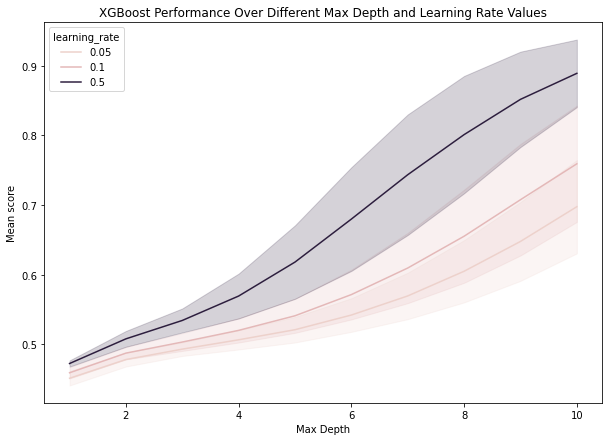

In [214]:
plt.figure(figsize=(10, 7))

sns.lineplot(x="max_depth", y="mean_score", hue = 'learning_rate', data=results_up)

# set the plot title and axes labels
plt.title("XGBoost Performance Over Different Max Depth and Learning Rate Values")
plt.xlabel("Max Depth")
plt.ylabel("Mean score")

plt.show()

Using the upsampled data the model performs better with a learning rate of 0.5, the mean score has improved significantly as compared to the imbalanced data. Model performance across all learning rates improves steadily with increased max depth. Increasing the max depth values could potentially improve the model performance, but I will not explore this in this notebook. 
I can get the optimal parameters from gridsearch using `best_estimator_`.

In [112]:
up_grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

The optimized model parameters are max depth = 10, learning rate = 0.5, and n_estimators = 500. I'm going to re-fit an XGBClassifier using these parameters to see how the model is making predictions with the upsampled data.

In [117]:
# instantiate the model
up_xgb = XGBClassifier(learning_rate = 0.5, random_state = 10, max_depth = 10, n_estimators = 500)

# fit the model
up_xgb = up_xgb.fit(X_train_up, y_train_up)

# get the training and validation scores
print(f"The Training accuracy is:  {up_xgb.score(X_train_up, y_train_up)}")
print(f"The Validation accuracy is:  {up_xgb.score(X_validation, y_validation)}")

The Training accuracy is:  0.9952026439023388
The Validation accuracy is:  0.7126840760323222


The model has overfit to the training data, but I'm more interested in how it has predicted classes 2 and 3.

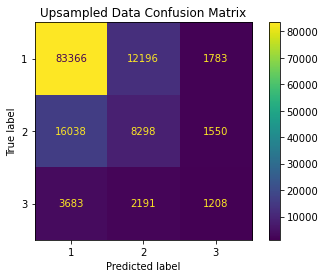

In [118]:
plot_confusion_matrix(up_xgb, X_validation, y_validation)
plt.title("Upsampled Data Confusion Matrix");

The predictions made for classes 2 and 3 have nearly doubled as compared to the imbalanced data, this is a huge improvement. Calculating the f1-scores will give a better indication of the results.

In [119]:
y_predictions_up = up_xgb.predict(X_validation)

In [120]:
report_up = classification_report(y_validation, y_predictions_up)
print(report_up)

              precision    recall  f1-score   support

           1       0.81      0.86      0.83     97345
           2       0.37      0.32      0.34     25886
           3       0.27      0.17      0.21      7082

    accuracy                           0.71    130313
   macro avg       0.48      0.45      0.46    130313
weighted avg       0.69      0.71      0.70    130313



As expected from the confusion matrix the f1-scores for classes 2 and 3 have improved significantly. They're still relatively low overall but this is a big improvement from the imbalanced data. Next, I will run a final gridsearch using the downsampled data to see if I can further improve the results.

---

### Model Optimization with Downsampled Data

Read in the downsampled data.

In [121]:
X_train_down = pd.read_pickle("data/X_train_under.pkl")
y_train_down = pd.read_pickle("data/y_train_under.pkl")

Use gridsearch and the same parameters as above.

In [122]:
# instantiate the model
my_xgb = XGBClassifier()

# set the parameters for the grid
parameters = {'n_estimators': [100, 500],
              'learning_rate': [0.05, 0.1, 0.5],
              'max_depth': np.arange(1, 10, 2)}

#instantiate the grid
down_grid = GridSearchCV(my_xgb, param_grid = parameters, verbose = 2, cv = 5)

#fit the grid
down_grid.fit(X_train_down, y_train_down)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END ..learning_rate=0.05, max_depth=1, n_estimators=100; total time=   0.9s
[CV] END ..learning_rate=0.05, max_depth=1, n_estimators=100; total time=   0.9s
[CV] END ..learning_rate=0.05, max_depth=1, n_estimators=100; total time=   1.0s
[CV] END ..learning_rate=0.05, max_depth=1, n_estimators=100; total time=   1.0s
[CV] END ..learning_rate=0.05, max_depth=1, n_estimators=100; total time=   0.9s
[CV] END ..learning_rate=0.05, max_depth=1, n_estimators=500; total time=   4.6s
[CV] END ..learning_rate=0.05, max_depth=1, n_estimators=500; total time=   4.5s
[CV] END ..learning_rate=0.05, max_depth=1, n_estimators=500; total time=   4.6s
[CV] END ..learning_rate=0.05, max_depth=1, n_estimators=500; total time=   4.3s
[CV] END ..learning_rate=0.05, max_depth=1, n_estimators=500; total time=   4.1s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   2.0s
[CV] END ..learning_rate=0.05, max_depth=3, n_e

[CV] END ...learning_rate=0.5, max_depth=1, n_estimators=100; total time=   0.8s
[CV] END ...learning_rate=0.5, max_depth=1, n_estimators=100; total time=   0.7s
[CV] END ...learning_rate=0.5, max_depth=1, n_estimators=100; total time=   0.8s
[CV] END ...learning_rate=0.5, max_depth=1, n_estimators=100; total time=   1.0s
[CV] END ...learning_rate=0.5, max_depth=1, n_estimators=500; total time=   3.8s
[CV] END ...learning_rate=0.5, max_depth=1, n_estimators=500; total time=   4.0s
[CV] END ...learning_rate=0.5, max_depth=1, n_estimators=500; total time=   4.2s
[CV] END ...learning_rate=0.5, max_depth=1, n_estimators=500; total time=   4.1s
[CV] END ...learning_rate=0.5, max_depth=1, n_estimators=500; total time=   4.4s
[CV] END ...learning_rate=0.5, max_depth=3, n_estimators=100; total time=   1.8s
[CV] END ...learning_rate=0.5, max_depth=3, n_estimators=100; total time=   1.9s
[CV] END ...learning_rate=0.5, max_depth=3, n_estimators=100; total time=   2.1s
[CV] END ...learning_rate=0.

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

Save the model output.

In [138]:
joblib.dump(down_grid, 'xgb_down.pkl')

['xgb_down.pkl']

Store the results of gridsearch in a dataframe.

In [215]:
results_down = pd.DataFrame({
    "n_estimators": down_grid.cv_results_["param_n_estimators"],
    'max_depth': down_grid.cv_results_["param_max_depth"],
    'mean_score': down_grid.cv_results_["mean_test_score"],
    'learning_rate': down_grid.cv_results_["param_learning_rate"]
})

results_down

,n_estimators,max_depth,mean_score,learning_rate
0,100,1,0.443638,0.05
1,500,1,0.461490,0.05
2,100,3,0.480170,0.05
3,500,3,0.495018,0.05
4,100,5,0.494836,0.05
5,500,5,0.506677,0.05
6,100,7,0.507060,0.05
7,500,7,0.517167,0.05
8,100,9,0.520031,0.05
9,500,9,0.524611,0.05


Plot the results.

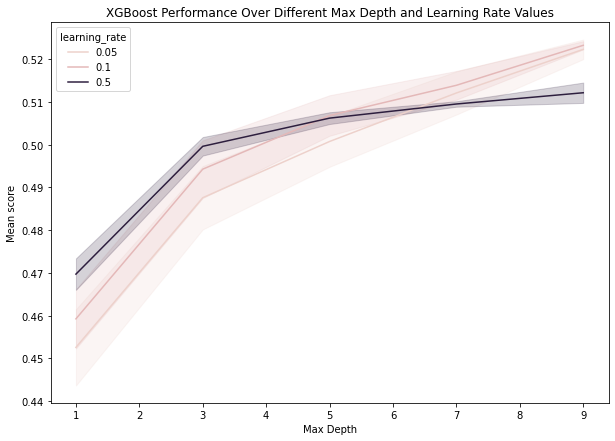

In [216]:
plt.figure(figsize = (10, 7))

sns.lineplot(x = "max_depth", y = "mean_score", hue = 'learning_rate', data = results_down)

# set the plot title and axes labels
plt.title("XGBoost Performance Over Different Max Depth and Learning Rate Values")
plt.xlabel("Max Depth")
plt.ylabel("Mean score")

plt.show()

The mean scores are much lower than with the upsampled data. The learning rate of 0.5 performs the worst overall. The learning rates of 0.05 and 0.1 perform similarly, both reaching their highest mean score values at a max depth of 9. Increasing the max depth values could potentially improve the model performance, as with the upsampled data, but I will not explore this in this notebook due to the run-time needed to fit the gridsearch on so many parameters.

Get the best model parameters from gridsearch using `best_estimator_`.

In [129]:
down_grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Gridsearch selected a max depth of 9, a learning rate of 0.05 and 500 estimators as the optimal parameters.

Fit a XGBClassifier using the optimized parameters to see how the model is making predictions.

In [130]:
down_xgb = XGBClassifier(learning_rate = 0.05, random_state = 10, max_depth = 9, n_estimators = 500)

down_xgb = down_xgb.fit(X_train_down, y_train_down)

print(f"The Training accuracy is:  {down_xgb.score(X_train_down, y_train_down)}")
print(f"The Validation accuracy is:  {down_xgb.score(X_validation, y_validation)}")

The Training accuracy is:  0.8346849027676915
The Validation accuracy is:  0.5616630727555961


The training accuracy is substantially higher than the validation accuracy, meaning that the model has overfit to the training data. I will check the confusion matrix and classification report to get a better idea of the predictions the model is making. 

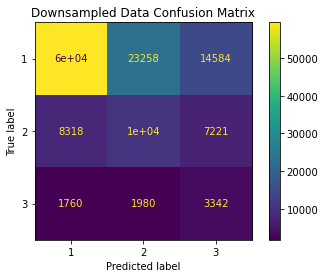

In [131]:
plot_confusion_matrix(down_xgb, X_validation, y_validation)
plt.title("Downsampled Data Confusion Matrix");

The number of predictions for classes 2 and 3 has improved even more than with the upsampled data. The model is now making more correct predictions for these classes than incorrect predictions.

In [133]:
y_predictions_down = down_xgb.predict(X_validation)

In [134]:
report_down = classification_report(y_validation, y_predictions_down)
print(report_down)

              precision    recall  f1-score   support

           1       0.86      0.61      0.71     97345
           2       0.29      0.40      0.34     25886
           3       0.13      0.47      0.21      7082

    accuracy                           0.56    130313
   macro avg       0.43      0.49      0.42    130313
weighted avg       0.70      0.56      0.61    130313



The f1-scores are the same as for the upsampled data, but the recall scores for classes 2 and 3 have improved significantly. Using the downsampled data I get the best performing model.

---

## Model Summary Table

The results of the classification reports of each model are summarized in the table below.

| Data        | Class   | Precision | Recall | F1   |
|-------------|---------|-----------|--------|------|
| Original    |         |           |        |      |
|             | Class 1 | 0.78      | 0.97   | 0.87 |
|             | Class 2 | 0.51      | 0.17   | 0.26 |
|             | Class 3 | 0.56      | 0.09   | 0.16 |
| Upsampled   |         |           |        |      |
|             | Class 1 | 0.81      | 0.86   | 0.83 |
|             | Class 2 | 0.37      | 0.32   | 0.34 |
|             | Class 3 | 0.27      | 0.17   | 0.21 |
| Downsampled |         |           |        |      |
|             | Class 1 | 0.86      | 0.61   | 0.71 |
|             | Class 2 | 0.29      | 0.40   | 0.34 |
|             | Class 3 | 0.13      | 0.47   | 0.21 |

---

## Feature Evaluation

Since I got the best results using the downsampled data I will evaluate the features using this model.

Install shap using conda install.

In [144]:
conda install -c conda-forge shap

Solving environment: done

## Package Plan ##

  environment location: /Users/stephgolob/opt/anaconda3/envs/boosting

  added / updated specs:
    - shap


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cloudpickle-2.1.0          |     pyhd8ed1ab_0          25 KB  conda-forge
    colorama-0.4.5             |     pyhd8ed1ab_0          18 KB  conda-forge
    libcxx-14.0.6              |       hce7ea42_0         1.3 MB  conda-forge
    libllvm11-11.1.0           |       hd011deb_3        22.5 MB  conda-forge
    libzlib-1.2.12             |       hfe4f2af_1          63 KB  conda-forge
    llvm-openmp-14.0.4         |       ha654fa7_0         329 KB  conda-forge
    llvmlite-0.38.1            |   py38h1e1b051_0         241 KB  conda-forge
    numba-0.55.2               |   py38h1f551d2_0         3.8 MB  conda-forge
    shap-0.41.0                |   py38h2b30649_0         582 KB  conda-forg

Use shap `TreeExplainer` to calculate shap values for the XGBClassifier model.

In [146]:
# use the XGB model with downsampled data
explainer = shap.TreeExplainer(down_xgb)

# use the explainer to calculate the shap values and input the downsampled X_train_down data
shap_values = explainer.shap_values(X_train_down)

In [147]:
# create a list of the class names to be used in the shap summary plot
class_names = ["on-time", "0-30 min delay", "30-120 min delay"]

Plot the shap values using `summary_plot`. I'm plotting the values individually for each class to make interpretation easier. 

Shap summary plot for class 1 (On-time flights).

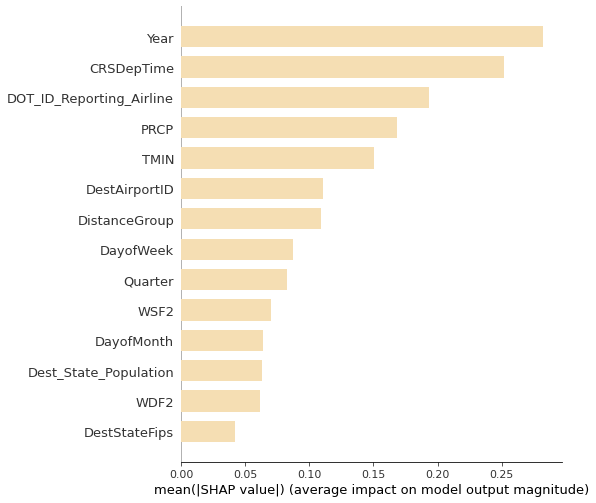

In [218]:
# Initiate Javascript for visualization 
shap.initjs()

shap.summary_plot(shap_values[0], X_train_down.values, 
                  plot_type = "bar", class_names = class_names, 
                  feature_names = X_train.columns, color = "wheat")

The results of the shapley summary plot show that Year is the biggest predictor of on-time flights.

---

Shap summary plot for class 2 (0-30 minute flight delay).

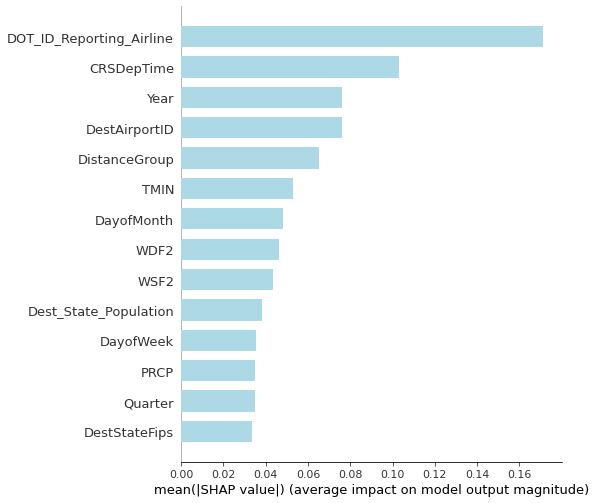

In [221]:
# Initiate Javascript for visualization 
shap.initjs()

shap.summary_plot(shap_values[1], X_train_down.values, 
                  plot_type = "bar", class_names = class_names, 
                  feature_names = X_train.columns, color = "lightblue")

The results of the shapley summary plot show that Reporting Airline is the biggest predictor of 0-30 minute delayed flights.

---

Shap summary plot for class 3 (30-120 minute flight delay).

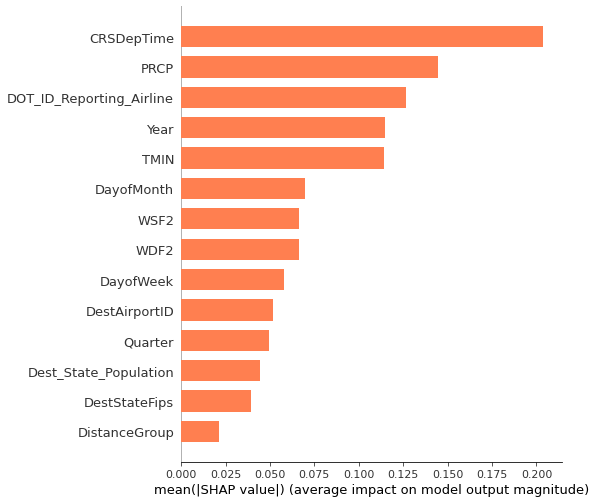

In [222]:
# Initiate Javascript for visualization 
shap.initjs()

shap.summary_plot(shap_values[2], X_train_down.values, 
                  plot_type = "bar", class_names = class_names, 
                  feature_names = X_train.columns, color = "coral")

The results of the shapley summary plot show that Departure Time is the biggest predictor of 30-120 minute delayed flights.

---

The plots above show which features are most important in predicting each class, but they don't show how the feature values are affecting the predictions.

The same shapley values can be used for global interpretation of the features. Plots are created for each class and explained below.

Class 1.

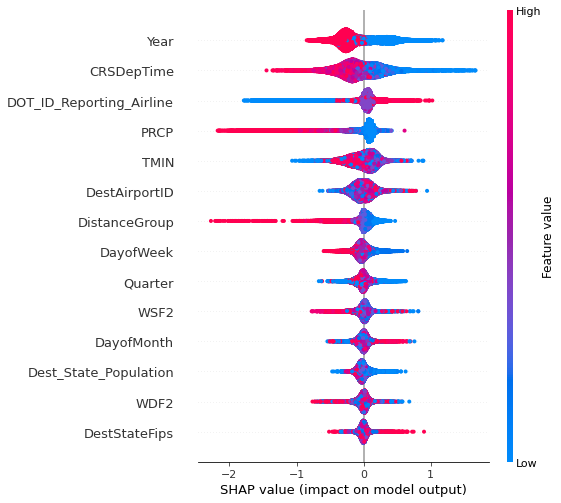

In [223]:
# Initiate Javascript for visualization 
shap.initjs()

shap.summary_plot(shap_values[0], X_train_down.values, feature_names = X_train.columns)

As shown above Year is the biggest predictor for on-time flights. This plot shows that higher values for Year (2021) have a negative impact on predicting on-time flights, meaning that more flights were on-time in 2020. This plot also shows that earlier departure times have a positive impact on predicting on-time flights.

---

Class 2.

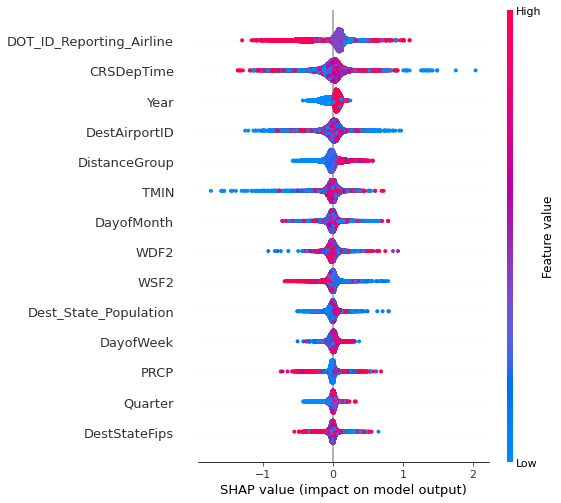

In [224]:
# Initiate Javascript for visualization 
shap.initjs()

shap.summary_plot(shap_values[1], X_train_down.values, feature_names = X_train.columns)

For class 2 the Reporting Airline was the biggest predictor, this plot shows that certain airlines are more predictive of a delay.

---

Class 3.

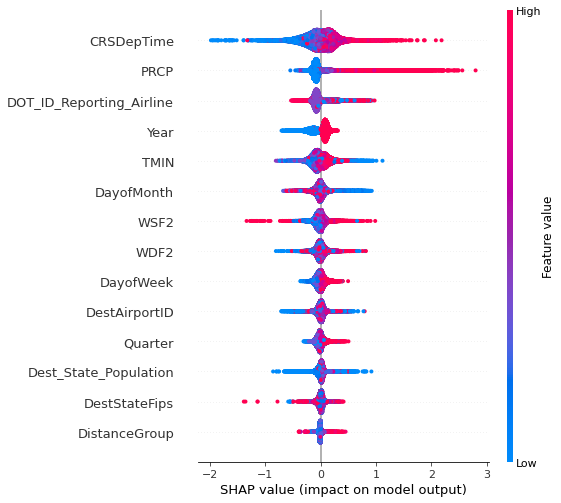

In [225]:
# Initiate Javascript for visualization 
shap.initjs()

shap.summary_plot(shap_values[2], X_train_down.values, feature_names = X_train.columns)

For class 3 Departure Time was the biggest predictor, this plot shows that a later departure time is a bigger predictor of extreme delays. Precipitation was also a strong predictor for this class, with more precipitation being a bigger predictor of flight delays greater than 30 minutes.

---

## Results Using Test Data

The best results I got from all of the models and all of the datasets was using an XGBoost Classifier on the downsampled data. In this next step I will use the test data to get a final model evaluation.

Read in the X_test and y_tests data sets.

In [226]:
X_test = pd.read_pickle("data/X_test.pkl")
y_test = pd.read_pickle("data/y_test.pkl")

Calculate predictions using X_test.

In [227]:
y_predictions_down2 = down_xgb.predict(X_test)

Create a classification report.

In [228]:
report_down2 = classification_report(y_test, y_predictions_down2)
print(report_down2)

              precision    recall  f1-score   support

           1       0.86      0.61      0.71     81121
           2       0.29      0.40      0.34     21571
           3       0.13      0.48      0.21      5902

    accuracy                           0.56    108594
   macro avg       0.43      0.50      0.42    108594
weighted avg       0.70      0.56      0.61    108594



Plot the results of the confusion matrix and print the classification report.

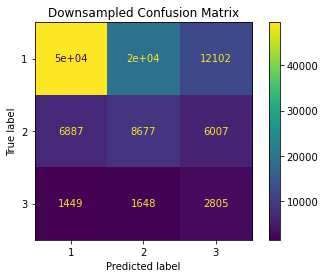


Downsampled data classification report: 
               precision    recall  f1-score   support

           1       0.86      0.61      0.71     81121
           2       0.29      0.40      0.34     21571
           3       0.13      0.48      0.21      5902

    accuracy                           0.56    108594
   macro avg       0.43      0.50      0.42    108594
weighted avg       0.70      0.56      0.61    108594



In [231]:
# Model on the downsampled data
plot_confusion_matrix(down_xgb, X_test, y_test)
plt.title('Downsampled Confusion Matrix')

plt.show()

print_line = "\n=======================================================\n"

print("\nDownsampled data classification report:", print_line, report_down2)

## Conclusions

Using the model trained on the downsampled data the test data performs similarly to the validation data. The f1-scores remain the same, but the recall scores for class 3 have actually improved, albeit slightly (from 0.47 to 0.48). 

---